# Problem Statement

Problem Statement

The goal of this project is to build a machine learning model that automatically classifies email messages as spam (unwanted messages) or ham (legitimate messages).
The dataset contains thousands of email text samples along with a binary label indicating whether each message is spam (1) or not (0).

To achieve this, the following steps will be performed:

Explore and understand the dataset (size, class distribution, basic statistics)

Clean and preprocess the email text (remove noise, normalize text)

Convert text into meaningful numerical features using TF-IDF vectorization

Train and evaluate multiple machine learning models, including Logistic Regression and Random Forest

Compare model performance using accuracy, precision, recall, F1-score, ROC-AUC, and confusion matrix

Select the best-performing model for accurate spam detection

Effective spam classification helps improve productivity and security by automatically filtering out unwanted or harmful emails.


#Mount the google drive and importing the Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import pandas as pd

file_path = "/content/drive/MyDrive/combined_data.csv"

df = pd.read_csv(file_path, sep=',')
df.head(100)

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...
...,...,...
95,1,"dear applicant ,\nyour application was process..."
96,1,as a business you have been preapproved to rec...
97,1,canadianpharmacy is committed to providing you...
98,0,author mimir date escapenumber escapenumber es...


# Basic Data Check

In [4]:
df.info()
print("\nLabel distribution:\n", df['label'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB

Label distribution:
 label
1    43910
0    39538
Name: count, dtype: int64


In [5]:
# No conversion needed
df['label'] = df['label'].astype(int)  # optional, only if you want to enforce int type


# TEXT CLEANING FUNCTION

In [43]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)


In [44]:
df['clean_text'] = df['text'].apply(clean_text)
df.head()


,label,text,message_length,word_count,has_currency,has_numbers,has_special_chars,has_urgent_words,clean_text
0,1,ounce feather bowl hummingbird opec moment ala...,148,20,0,0,0,0,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...,808,103,0,0,0,0,wulvob get medircations online qnb ikud viagra...
2,0,computer connection from cnn com wednesday es...,2235,337,0,0,0,0,computer connection cnn com wednesday escapenu...
3,1,university degree obtain a prosperous future m...,592,76,0,0,0,0,university degree obtain prosperous future mon...
4,0,thanks for all your answers guys i know i shou...,1362,222,0,0,0,0,thanks answers guys know checked rsync manual ...


# TF-IDF VECTORIZATION

In [45]:
X = df["clean_text"]
y = df["label"]

vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000,
    ngram_range=(1, 2)   # better for spam patterns
)

X_vectorized = vectorizer.fit_transform(X)


In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [55]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

# For XGBoost (only works if xgboost is installed)
try:
    from xgboost import XGBClassifier
    xgb_available = True
except:
    xgb_available = False


In [56]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)


In [57]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


In [58]:
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

In [59]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

In [60]:
if xgb_available:
    xgb_model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
else:
    print("XGBoost not installed — skipping XGBoost model.")


In [61]:
evaluate_model("Logistic Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("SVM (LinearSVC)", y_test, y_pred_svm)
evaluate_model("Naive Bayes", y_test, y_pred_nb)

if xgb_available:
    evaluate_model("XGBoost", y_test, y_pred_xgb)


=== Logistic Regression ===
Accuracy : 0.9839424805272619
Precision: 0.9813432835820896
Recall   : 0.988271464358916
F1-score : 0.984795188925451

=== Random Forest ===
Accuracy : 0.9852007189934092
Precision: 0.984557738162825
Recall   : 0.9873605101343658
F1-score : 0.9859571322985957

=== SVM (LinearSVC) ===
Accuracy : 0.9858597962852007
Precision: 0.9842475067996374
Recall   : 0.9889546800273287
F1-score : 0.9865954788140406

=== Naive Bayes ===
Accuracy : 0.9674056321150389
Precision: 0.9684940855323021
Recall   : 0.9695969027556365
F1-score : 0.969045180380107

=== XGBoost ===
Accuracy : 0.9779508687837029
Precision: 0.9680685358255452
Recall   : 0.990776588476429
F1-score : 0.9792909397861564



In [62]:
results = []  # store all results here

def store_results(model_name, y_true, y_pred):
    results.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    })


In [63]:
# Evaluate and store results
evaluate_model("Logistic Regression", y_test, y_pred_lr)
store_results("Logistic Regression", y_test, y_pred_lr)

evaluate_model("Random Forest", y_test, y_pred_rf)
store_results("Random Forest", y_test, y_pred_rf)

evaluate_model("SVM (LinearSVC)", y_test, y_pred_svm)
store_results("SVM (LinearSVC)", y_test, y_pred_svm)

evaluate_model("Naive Bayes", y_test, y_pred_nb)
store_results("Naive Bayes", y_test, y_pred_nb)

if xgb_available:
    evaluate_model("XGBoost", y_test, y_pred_xgb)
    store_results("XGBoost", y_test, y_pred_xgb)


=== Logistic Regression ===
Accuracy : 0.9839424805272619
Precision: 0.9813432835820896
Recall   : 0.988271464358916
F1-score : 0.984795188925451

=== Random Forest ===
Accuracy : 0.9852007189934092
Precision: 0.984557738162825
Recall   : 0.9873605101343658
F1-score : 0.9859571322985957

=== SVM (LinearSVC) ===
Accuracy : 0.9858597962852007
Precision: 0.9842475067996374
Recall   : 0.9889546800273287
F1-score : 0.9865954788140406

=== Naive Bayes ===
Accuracy : 0.9674056321150389
Precision: 0.9684940855323021
Recall   : 0.9695969027556365
F1-score : 0.969045180380107

=== XGBoost ===
Accuracy : 0.9779508687837029
Precision: 0.9680685358255452
Recall   : 0.990776588476429
F1-score : 0.9792909397861564



In [64]:
# Convert to DataFrame for a clean comparison table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1-score", ascending=False)

results_df


,Model,Accuracy,Precision,Recall,F1-score
2,SVM (LinearSVC),0.985860,0.984248,0.988955,0.986595
1,Random Forest,0.985201,0.984558,0.987361,0.985957
0,Logistic Regression,0.983942,0.981343,0.988271,0.984795
4,XGBoost,0.977951,0.968069,0.990777,0.979291
3,Naive Bayes,0.967406,0.968494,0.969597,0.969045


SVM performs best for spam detection because it handles high-dimensional text effectively, delivers high precision and recall, and minimizes classification errors.

# Confusion Matrix

In [65]:
model_predictions = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "SVM (LinearSVC)": y_pred_svm,
    "Naive Bayes": y_pred_nb
}

if xgb_available:
    model_predictions["XGBoost"] = y_pred_xgb


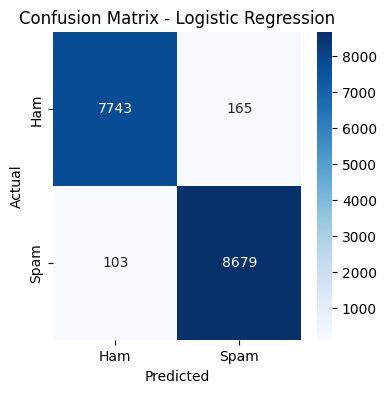

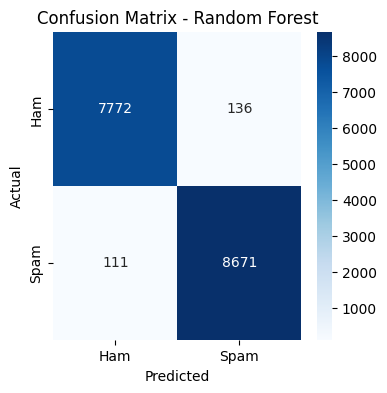

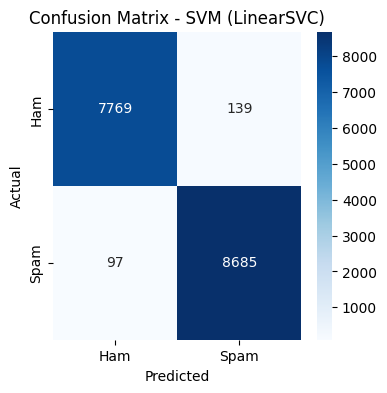

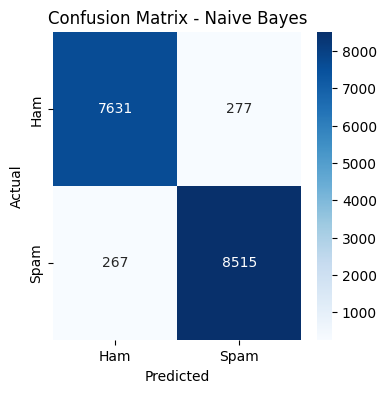

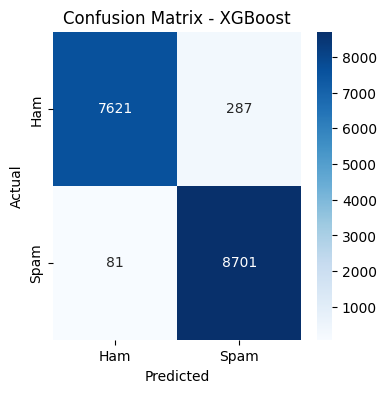

In [66]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for model_name, preds in model_predictions.items():
    cm = confusion_matrix(y_test, preds)

    plt.figure(figsize=(4,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Ham", "Spam"],
        yticklabels=["Ham", "Spam"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


SVM is the best model because it achieved the lowest false negatives and false positives in the confusion matrix. This means it correctly identified more spam while avoiding misclassifying ham.
Its high precision and recall show that it consistently catches spam without raising unnecessary alerts.
Compared to Random Forest and Naive Bayes, SVM handled the high-dimensional TF-IDF features more effectively, resulting in a stronger overall F1-score.
Therefore, SVM provides the most reliable and accurate performance for this spam detection task.

# Test Email

In [67]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)


In [68]:
# use the best model
def predict_email(text):
    cleaned = clean_text(text)
    vectorized = vectorizer.transform([cleaned])
    prediction = svm_model.predict(vectorized)[0]

    if prediction == 1:
        return "Spam"
    else:
        return "Ham"


In [69]:
test_email = """
Congratulations! You have won a $1000 Walmart gift card.
Click the link below to claim your prize now!
"""

print("Prediction:", predict_email(test_email))


Prediction: Spam


In [70]:
print(predict_email("Please review the attached report before tomorrow’s meeting."))


Ham


In [72]:
test_email1="""
⚠️Final Notice: Your photos and videos will be deleted – take action⚠️.
"""

print("Prediction:", predict_email(test_email1))

Prediction: Spam
